# Custom Dissimilarities

This notebook is an example on how to use the tensorflow implementation of the Dissimilarity Mixture Autoencoder (DMAE) with a custom dissimilarity function.

In [1]:
# Required libraries
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import colors
plt.style.use("ggplot")
%matplotlib inline

# Path of the DMAE library
import sys, itertools
# sys.path.append("/tf/home/repositorios/DMAE/") # how to use the code in other location
sys.path.append("../../")
import DMAE

# Setting random seed
np.random.seed(0)
tf.random.set_seed(0)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# Imporing some helper functions to visualize and understand the results
import vis_utils

## Toroidal Isotropicly Distributed Blobs

First, we're going to define isotropic Gaussian blobs with toroidal properties, the points that are outside of the boundaries $[-1, 1]$ are mirrored on each axis:

Text(0.5, 1.0, 'Generated Data')

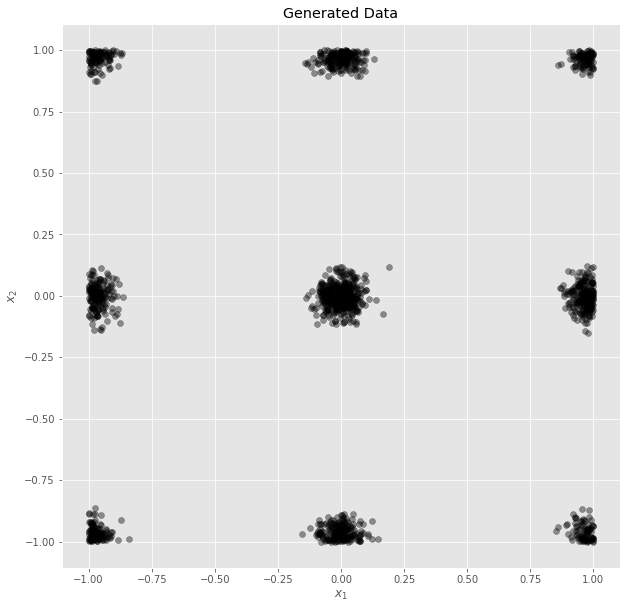

In [2]:
# Number of samples to generate
n_samples = 1600
X, _ = make_blobs(n_samples=n_samples, centers=[(1.0, 0.0), (-1.0, 1.0), (0.0, -1.0), (0, 0)], cluster_std=0.05)
X = np.float32(X)
X[X>1] = X[X>1]-2
X[X<-1] = X[X<-1]+2
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c="k", alpha=0.4)
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.title("Generated Data")

Now, we define some hyperparameters:

In [3]:
# Number of clusters
n_clusters = 4
# Softmax inverse temperature parameter
alpha = 100
# Training parameters
batch_size = 256
epochs = 200
lr = 1e-3

Let us define an appropriate dissimilarity for this problem. We define the ```toroidal_pairwise``` function, which is a pairwise dissimilarity that measures the squared distance between points and clusters while considering toroidal properties:

In [4]:
def toroidal_dis(x_i, Y, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((x_i-Y)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        d = tf.minimum(tf.reduce_sum((x_i-Y+delta)**2, axis=1), d)
    return d

def toroidal_pairwise(X, Y, interval=tf.constant((1.0, 1.0))):
    func = lambda x_i: toroidal_dis(x_i, Y, interval)
    Z = tf.vectorized_map(func, X)
    return Z

Likewise, we define the loss function for this dissimilarity:

In [5]:
def toroidal_loss(X, mu_tilde, pi_tilde, alpha, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((X-mu_tilde)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        d = tf.minimum(tf.reduce_sum((X-mu_tilde+delta)**2, axis=1), d)
    return tf.reduce_sum(d-tf.math.log(pi_tilde)/alpha)

In [6]:
interval = tf.constant((2.0, 2.0))
dis = lambda X, Y: toroidal_pairwise(X, Y, interval)
dmae_loss = lambda X, mu_tilde, pi_tilde, alpha: toroidal_loss(X, mu_tilde, pi_tilde, alpha, interval)

Defining the shallow DMAE model:

In [7]:
inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoder(alpha=alpha, n_clusters=n_clusters,
                                                          initializers={"centers": DMAE.Initializers.InitPlusPlus(X, n_clusters, dis, 50),
                                                                        "mixers": tf.keras.initializers.Constant(1.0)},
                                                          trainable = {"centers": True, "mixers": False},
                                                          dissimilarity=dis)(inp)
# DMAE model
model = tf.keras.Model(inputs=[inp], outputs=theta_tilde)
loss = dmae_loss(inp, *theta_tilde, alpha)
model.add_loss(loss)
model.compile(optimizer=tf.optimizers.Adam(lr=lr))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training the model:

In [8]:
model.fit(X, epochs=epochs, batch_size=batch_size)

Epoch 1/200
7/7 [==============================] - 0s 9ms/step - loss: 1.2870
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 1.1915
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 1.1326
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 1.1024
Epoch 5/200
7/7 [==============================] - 0s 5ms/step - loss: 1.0884
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 1.0829
Epoch 7/200
7/7 [==============================] - 0s 10ms/step - loss: 1.0813
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 1.0811
Epoch 9/200
7/7 [==============================] - 0s 5ms/step - loss: 1.0806
Epoch 10/200
7/7 [==============================] - 0s 8ms/step - loss: 1.0807
Epoch 11/200
7/7 [==============================] - 0s 6ms/step - loss: 1.0805
Epoch 12/200
7/7 [==============================] - 0s 6ms/step - loss: 1.0805
Epoch 13/200
7/7 [==============================] - 0s 6ms/s

7/7 [==============================] - 0s 7ms/step - loss: 1.0809
Epoch 105/200
7/7 [==============================] - 0s 7ms/step - loss: 1.0806
Epoch 106/200
7/7 [==============================] - 0s 6ms/step - loss: 1.0806
Epoch 107/200
7/7 [==============================] - 0s 8ms/step - loss: 1.0807
Epoch 108/200
7/7 [==============================] - 0s 8ms/step - loss: 1.0807
Epoch 109/200
7/7 [==============================] - 0s 6ms/step - loss: 1.0807
Epoch 110/200
7/7 [==============================] - 0s 7ms/step - loss: 1.0807
Epoch 111/200
7/7 [==============================] - 0s 7ms/step - loss: 1.0805
Epoch 112/200
7/7 [==============================] - 0s 7ms/step - loss: 1.0805
Epoch 113/200
7/7 [==============================] - 0s 6ms/step - loss: 1.0810
Epoch 114/200
7/7 [==============================] - 0s 6ms/step - loss: 1.0807
Epoch 115/200
7/7 [==============================] - 0s 5ms/step - loss: 1.0806
Epoch 116/200
7/7 [==============================] - 0

To visualize the results, we define an auxiliar model for the encoder:

In [9]:
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoder(alpha=0.1, n_clusters=n_clusters,
                                                  dissimilarity=dis,
                                                  trainable={"centers": False, "mixers": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model.layers[1].get_weights())

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Let's see the Voronoi regions:

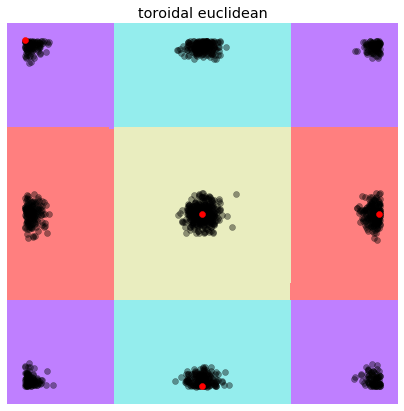

In [10]:
fig, ax = vis_utils.visualize_regions(DMAE_encoder, "toroidal euclidean", X, (7, 7), batch_size)

## Toroidal Anisotropicly Distributed Blobs

we're going to define anisotropic Gaussian blobs with toroidal properties, the points that are outside of the boundaries $[-1, 1]$ are mirrored on each axis:

Text(0.5, 1.0, 'Generated Data')

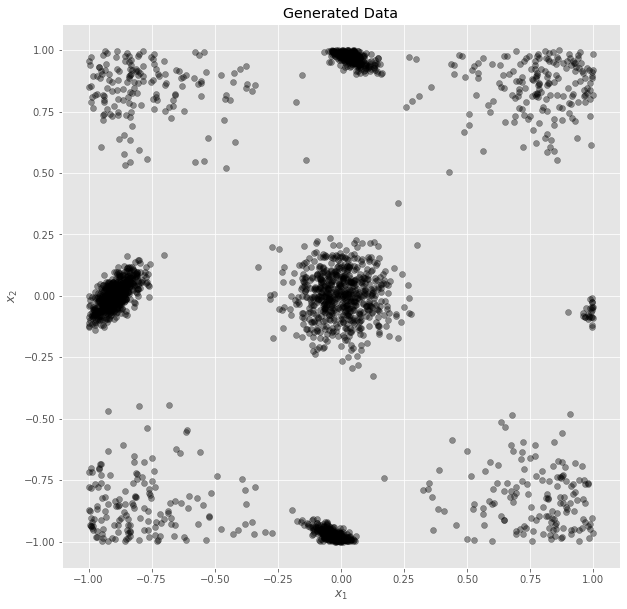

In [11]:
from scipy.stats import multivariate_normal
random_state = 170
means = np.array([[-0.9, 0.0],
                  [0.0, 1.0],
                  [-1.0, 1.0],
                  [0.0, 0.0]])
covs = np.array([[[0.2, 0.5],
                  [0.5, 0.2]],
                 
                 [[0.5, -0.2],
                  [-0.2, 0.3]],
                
                 [[3.0, 0.0],
                  [0.0, 2.0]],
                 
                 [[1.0, 0.0],
                  [0.0, 1.0]]])/10

X = []
for i in range(means.shape[0]):
    X.append(multivariate_normal.rvs(mean=means[i], cov=covs[i]@covs[i].T, size=640))
X = np.concatenate(X, axis=0)
X = np.float32(X)
X[X>1] = X[X>1]-2
X[X<-1] = X[X<-1]+2
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c="k", alpha=0.4)
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.title("Generated Data")

First, we train a model without covariances to determine appropriate starting means: 

In [13]:
inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoder(alpha=alpha, n_clusters=n_clusters,
                                                          initializers={"centers": DMAE.Initializers.InitPlusPlus(X, n_clusters, dis, 50),
                                                                        "mixers": tf.keras.initializers.Constant(1.0)},
                                                          trainable = {"centers": True, "mixers": False},
                                                          dissimilarity=dis)(inp)
# DMAE model
model = tf.keras.Model(inputs=[inp], outputs=theta_tilde)
loss = dmae_loss(inp, *theta_tilde, alpha)
model.add_loss(loss)
model.compile(optimizer=tf.optimizers.Adam(lr=lr))

In [14]:
model.fit(X, X, epochs=epochs, batch_size=batch_size)

Epoch 1/200
10/10 [==============================] - 0s 8ms/step - loss: 10.4657
Epoch 2/200
10/10 [==============================] - 0s 8ms/step - loss: 10.1260
Epoch 3/200
10/10 [==============================] - 0s 7ms/step - loss: 9.9448
Epoch 4/200
10/10 [==============================] - 0s 7ms/step - loss: 9.8026
Epoch 5/200
10/10 [==============================] - 0s 7ms/step - loss: 9.7238
Epoch 6/200
10/10 [==============================] - 0s 7ms/step - loss: 9.6776
Epoch 7/200
10/10 [==============================] - 0s 9ms/step - loss: 9.6423
Epoch 8/200
10/10 [==============================] - 0s 5ms/step - loss: 9.6197
Epoch 9/200
10/10 [==============================] - 0s 4ms/step - loss: 9.5946
Epoch 10/200
10/10 [==============================] - 0s 7ms/step - loss: 9.5908
Epoch 11/200
10/10 [==============================] - 0s 6ms/step - loss: 9.5625
Epoch 12/200
10/10 [==============================] - 0s 6ms/step - loss: 9.5757
Epoch 13/200
10/10 [===============

10/10 [==============================] - 0s 6ms/step - loss: 9.5566
Epoch 103/200
10/10 [==============================] - 0s 6ms/step - loss: 9.6026
Epoch 104/200
10/10 [==============================] - 0s 7ms/step - loss: 9.5563
Epoch 105/200
10/10 [==============================] - 0s 6ms/step - loss: 9.5465
Epoch 106/200
10/10 [==============================] - 0s 4ms/step - loss: 9.5347
Epoch 107/200
10/10 [==============================] - 0s 5ms/step - loss: 9.5619
Epoch 108/200
10/10 [==============================] - 0s 5ms/step - loss: 9.5353
Epoch 109/200
10/10 [==============================] - 0s 4ms/step - loss: 9.5879
Epoch 110/200
10/10 [==============================] - 0s 5ms/step - loss: 9.5362
Epoch 111/200
10/10 [==============================] - 0s 4ms/step - loss: 9.5383
Epoch 112/200
10/10 [==============================] - 0s 5ms/step - loss: 9.5629
Epoch 113/200
10/10 [==============================] - 0s 5ms/step - loss: 9.6291
Epoch 114/200
10/10 [=========

Now we define a toroidal version of the Mahalanobis dissimilarity:

In [24]:
def toroidal_mahalanobis(x_i, Y, cov, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((x_i-Y)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        diff = tf.expand_dims(x_i-Y+delta, axis=-1)
        d = tf.minimum(tf.squeeze(tf.reduce_sum(tf.matmul(cov, diff)*diff, axis=1)), d)
    return d

def toroidal_mahalanobis_pairwise(X, Y, cov, interval=tf.constant((1.0, 1.0))):
    func = lambda x_i: toroidal_mahalanobis(x_i, Y, cov, interval)
    Z = tf.vectorized_map(func, X)
    return Z

And its loss function

In [29]:
def toroidal_mahalanobis_loss(X, mu_tilde, Cov_tilde, pi_tilde, alpha, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((X-mu_tilde)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        diff = tf.expand_dims(X-mu_tilde+delta, axis=1)
        d = tf.minimum(tf.squeeze(tf.matmul(tf.matmul(diff, Cov_tilde), tf.transpose(diff, perm = [0, 2, 1]))), d)
    return tf.reduce_sum(d-tf.math.log(pi_tilde)/alpha)

In [30]:
interval = tf.constant((2.0, 2.0))
dis = lambda X, Y, cov: toroidal_mahalanobis_pairwise(X, Y, cov, interval)
dmae_loss = lambda X, theta, alpha: toroidal_mahalanobis_loss(X, *theta, alpha, interval)

Let us define the model:

In [31]:
inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoderCov(alpha=alpha, n_clusters=n_clusters,
                                                             initializers={"centers": tf.keras.initializers.RandomUniform(-1, 1),
                                                                           "cov": DMAE.Initializers.InitIdentityCov(X, n_clusters),
                                                                           "mixers": tf.keras.initializers.Constant(1.0)},
                                                             trainable = {"centers": True, "mixers": False, "cov": True},
                                                             dissimilarity=dis)(inp)
# DMAE model
model2 = tf.keras.Model(inputs=[inp], outputs=theta_tilde)

Now, we add the loss function and compile the model

In [32]:
loss = dmae_loss(inp, theta_tilde, alpha)
model2.add_loss(loss)
model2.compile(optimizer=tf.optimizers.Adam(lr=lr))

Now, we're going yo assign the initial means and covariances:

In [35]:
init_means = model.layers[1].get_weights()[0]
original_params = model2.layers[1].get_weights()
model2.layers[1].set_weights([init_means, *original_params[1:]])

Training the model:

In [36]:
model2.fit(X, epochs=75, batch_size=batch_size)

Epoch 1/75
10/10 [==============================] - 0s 10ms/step - loss: 9.6859
Epoch 2/75
10/10 [==============================] - 0s 12ms/step - loss: 9.4180
Epoch 3/75
10/10 [==============================] - 0s 12ms/step - loss: 9.2637
Epoch 4/75
10/10 [==============================] - 0s 13ms/step - loss: 9.0988
Epoch 5/75
10/10 [==============================] - 0s 17ms/step - loss: 9.0118
Epoch 6/75
10/10 [==============================] - 0s 15ms/step - loss: 8.9295
Epoch 7/75
10/10 [==============================] - 0s 17ms/step - loss: 8.8678
Epoch 8/75
10/10 [==============================] - 0s 15ms/step - loss: 8.7658
Epoch 9/75
10/10 [==============================] - 0s 17ms/step - loss: 8.7052
Epoch 10/75
10/10 [==============================] - 0s 16ms/step - loss: 8.6470
Epoch 11/75
10/10 [==============================] - 0s 15ms/step - loss: 8.5806
Epoch 12/75
10/10 [==============================] - 0s 14ms/step - loss: 8.5242
Epoch 13/75
10/10 [==================

To visualize the results, we define an auxiliar model for the encoder:

In [37]:
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoderCov(alpha=0.1, n_clusters=n_clusters,
                                                     dissimilarity=dis,
                                                     trainable={"centers": False, "mixers": False, "cov": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model2.layers[1].get_weights())

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Let's see the Voronoi regions:

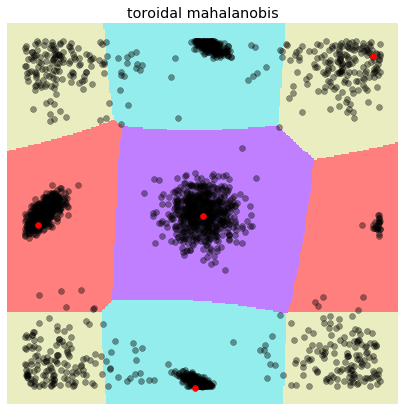

In [38]:
fig, ax = vis_utils.visualize_regions(DMAE_encoder, "toroidal mahalanobis", X, (7, 7), batch_size)